# Parallel External Source

In this tutorial we will show you how to enable parallel mode in `external_source` operator, allowing the `source` to be executed concurrently by Python worker processes. Doing so can reduce the execution time of each iteration by allowing source to run in the background, unblocking the main Python thread. Not every usage of `external_source` can be parallelized straight away - the `source` argument is subject to a set of restrictions and there is additional configuration required.

## Accepted `source`
Depending on a `batch` parameter, the `source` provided to parallel External Source is expected to either return batches or single samples. In the sample mode, DALI takes care of combining samples in batches and has more opportunities to parallelize computation of the input data. Therefore, the sample mode is a preferred way to run parallel External Source. Parallel External Source in the sample mode places following requirements on the source parameter:

1. `source` must be a callable: function or object. 
2. `source` callback must accept one argument: nvidia.dali.types.SampleInfo - indicating the index of requested sample.
3. Currently only per-sample (`batch=False`) mode is supported.
4. Data returned by the callback must be a CPU array (or tuple/list of them).

Following paragraphs will explain the reasoning behind those requirements and show examples of using the parallel External Source.
 

## Principle of Operation

Before every iteration, DALI External Source operator queries its `source` parameter for new data to pass it further for processing in the pipeline. The time necessary to obtain data from `source` by calling it (when the `source` is callable) or calling `next(source)` (in case of iterabe) can be significant and it can impact the time to process an iteration - especially as it's a blocking operation in the main Python thread.

Setting `parallel=True` for an `external_source` node indicates to the pipeline to run the `source` in Python worker processes started by DALI. The worker processes are bound to pipeline and shared by all parallel external sources in that pipeline.
Each of those workers keeps a **copy** of the `source` callback/object. The workers are separate processes, so keep in mind that they do not share any global state, only a copy of what was specified before starting them.

In the sample mode, each process can request a particular sample from its copy of `source` callback by invoking it with [SampleInfo](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/data_types.html#sampleinfo) object containing requested sample's index.   
DALI pipeline splits computation of samples needed for the next batches between the workers ahead of time and collects the data back for use in current iteration.

In the batch mode, DALI cannot request a particular sample to be returned, thus the benefits of parallelization are limited compared to the sample mode. If the `source` is a callable that accepts [BatchInfo](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/data_types.html#nvidia.dali.types.BatchInfo), a few batches can be prefetched in parallel. In case of iterables, the only benefit is running the iterable in a separate process.

Because the parallel sample mode can provide the biggest speed up, we present how to adapt iterable source to run in parallel sample mode.

## Example Pipeline and `source`

Let's take the simplified example from [ExternalSource Operator tutorial](external_input.ipynb). We will convert it to a callable object as a next step.

In [1]:
import numpy as np
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

batch_size = 4

class ExternalInputIterator:
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            file_label = [line.rstrip().split(' ') for line in f if line != '']
            self.files, self.labels = zip(*file_label)

    def __iter__(self):
        self.i = 0
        # Only full batches
        self.n = (len(self.files) // self.batch_size) * self.batch_size 
        return self

    def __next__(self):
        if self.i >= self.n:
            raise StopIteration()
        encoded_imgs, labels = [], []
        for _ in range(self.batch_size):
            jpeg_filename = self.files[self.i]
            label = self.labels[self.i]
            with open(self.images_dir + jpeg_filename, 'rb') as f:
                encoded_imgs.append(np.frombuffer(f.read(), dtype=np.uint8))
            labels.append(np.int32([label]))
            self.i += 1
        return encoded_imgs, labels

### Adjusting to Callable Object

We need to make two adjustments here:

1. Convert it to per-sample mode
2. Instead of returning the data sequentially in `__next__`, implement `__call__` that is able to return a specific sample.

We can keep the `__init__` that initializes the object. We no longer need `__iter__`.

Now, instead of the iterator keeping track of which sample (or batch) to return next, that information comes from DALI via the `sample_info` parameter - the member variables describing the index of sample are specified in the [SampleInfo type documentation](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/data_types.html#sampleinfo).

#### Epochs

Additionally, we precompute the numbers of full batches in the epoch. This way we will drop last, partial batch - alternatively, we could support padding the batch, but it is out of the scope of this tutorial. External Source in parallel mode does not support partial batches. 

**It is recommended that all copies of the `source` callback raise the `StopIteration` for the same `iteration` (and all sample indices for batch requested in that iteration).** 

This is why we computed the number of full batches and raise the `StopIteration` for any greater or equal iteration index.

After `StopIteration` was raised, we can call `pipeline.reset()` to reset the SampleInfo - DALI will start counting from the sample index and iteration index 0.

In [2]:
class ExternalInputCallable:
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            file_label = [line.rstrip().split(' ') for line in f if line != '']
            self.files, self.labels = zip(*file_label)
        self.full_iterations = len(self.files) // batch_size

    def __call__(self, sample_info): 
        sample_idx = sample_info.idx_in_epoch
        if sample_info.iteration >= self.full_iterations:
            # Indicate end of the epoch
            raise StopIteration()
        jpeg_filename = self.files[sample_idx]
        label = np.int32([self.labels[sample_idx]])
        with open(self.images_dir + jpeg_filename, 'rb') as f:
            encoded_img = np.frombuffer(f.read(), dtype=np.uint8)
        return encoded_img, label

The callable object is used only as an example. If you wish, you can use stateless function like:

In [3]:
def my_callback(sample_info):
    return np.full((5, 5), sample_info.idx_in_epoch)

#### Shuffling

To shuffle your dataset, you can permutate indices. The `source` callback can use some `permutation` function and when `source` is called with [SampleInfo](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/data_types.html#sampleinfo) instance, instead of returning `sample_info.idx_in_epoch`-th sample, return the `permutation(sample_info.idx_in_epoch)`-th one. 

Remember that you are dealing with multiple copies of the `source` callback. Every copy should shuffle the data in the same way, otherwise you risk mixing your dataset and returning the same sample multiple times in the same batch.

To shuffle the dataset between epochs, you can use `sample_info.epoch_idx` and parametrize the `permutation` with the `epoch_idx`.

This how the `ExternalInputCallable` example could be adapted to take care of shuffling the data between epochs.

In [4]:
class ExternalInputCallable:
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            file_label = [line.rstrip().split(' ') for line in f if line != '']
            self.files, self.labels = zip(*file_label)
        self.full_iterations = len(self.files) // batch_size
  
        self.perm = None  # permutation of indices
        self.last_seen_epoch = None  # so that we don't have to recompute the `self.perm` for every sample

    def __call__(self, sample_info): 
        if sample_info.iteration >= self.full_iterations:
            # Indicate end of the epoch
            raise StopIteration
        if self.last_seen_epoch != sample_info.epoch_idx:
            self.last_seen_epoch = sample_info.epoch_idx
            self.perm = np.random.default_rng(seed=42 + sample_info.epoch_idx).permutation(len(self.files))
        sample_idx = self.perm[sample_info.idx_in_epoch]
            
        jpeg_filename = self.files[sample_idx]
        label = np.int32([self.labels[sample_idx]])
        with open(self.images_dir + jpeg_filename, 'rb') as f:
            encoded_img = np.frombuffer(f.read(), dtype=np.uint8)
        return encoded_img, label

### Pipeline Definition

Now we can define two pipelines - **for now not using parallel mode** - to see that both methods give us the same results. 
Take a note that we set `batch=False` in the second example.

In [5]:
@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0)
def iterable_pipeline():
    jpegs, labels = fn.external_source(source=ExternalInputIterator(batch_size), num_outputs=2,
                                       dtype=[types.UINT8, types.INT32])
    decode = fn.decoders.image(jpegs, device="mixed")
    return decode, labels
    

@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0)
def callable_pipeline():
    jpegs, labels = fn.external_source(source=ExternalInputCallable(batch_size), num_outputs=2, batch=False,
                                       dtype=[types.UINT8, types.INT32])
    decode = fn.decoders.image(jpegs, device="mixed")
    return decode, labels

### Testing the Pipelines

Let's introduce some helper code to display the results.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

def display(outputs, count, columns=2, captions=None, cpu=False):
    rows = int(math.ceil(len(outputs) / columns))
    fig = plt.figure()
    fig.set_size_inches(16, 6 * rows)
    gs = gridspec.GridSpec(rows, columns)
    row = 0
    col = 0
    for i in range(count):
        plt.subplot(gs[i])
        plt.axis("off")
        if captions is not None:
            plt.title(captions[i])
        plt.imshow(outputs.at(i) if cpu else outputs.as_cpu().at(i))

And now we can build and run the pipelines.

In [7]:
iter_pipe = iterable_pipeline()
iter_pipe.build()
iter_out = iter_pipe.run()

call_pipe = callable_pipeline()
call_pipe.build()
call_out = call_pipe.run()

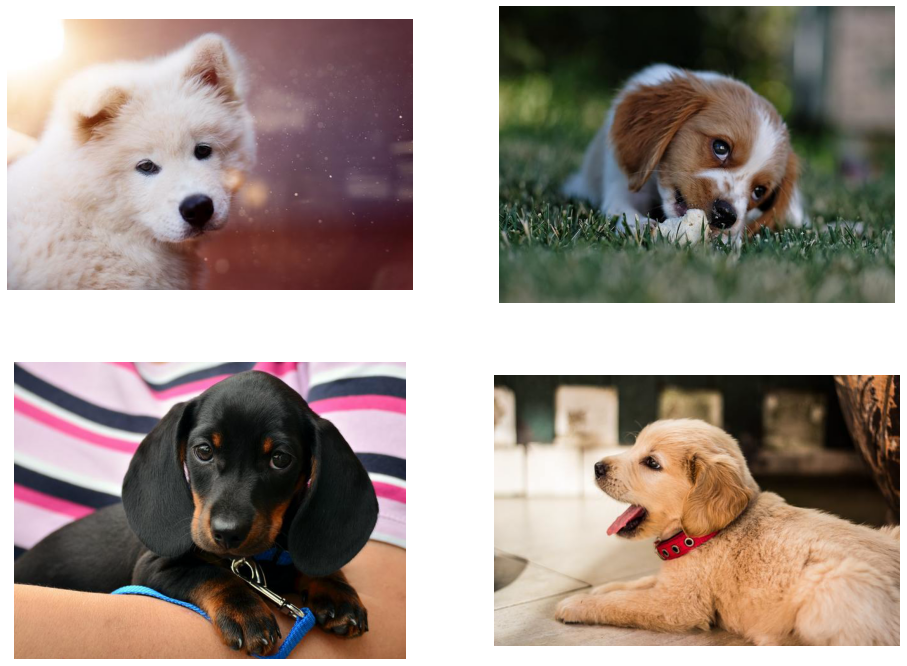

In [8]:
display(iter_out[0], batch_size)

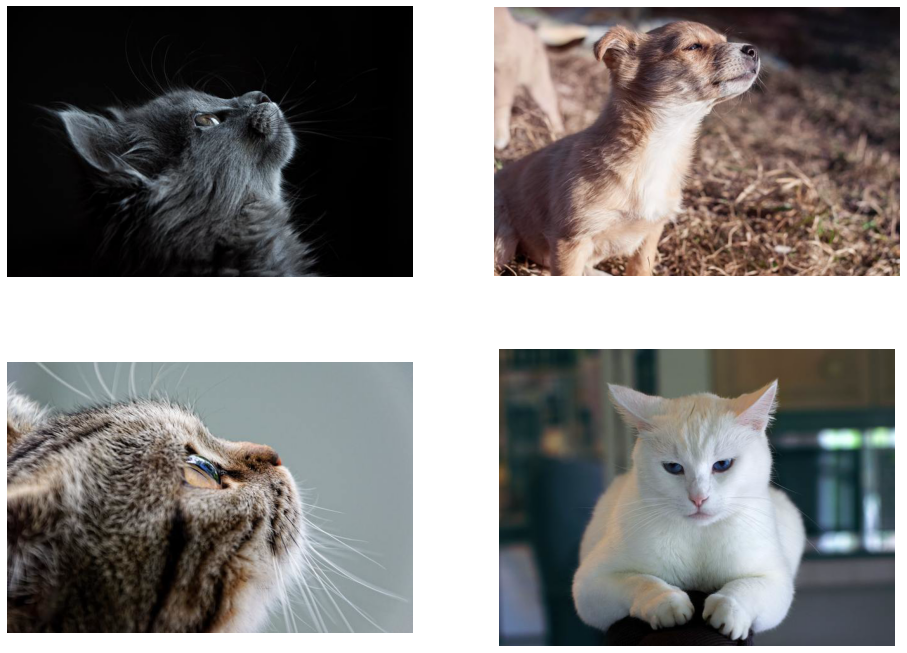

In [9]:
display(call_out[0], batch_size)

## Going Parallel
Now that we have a pipeline with a callable `source` that is compatible with the parallel `external_source` requirements, we can adjust our pipeline. We need to modify our `callable_pipeline`, by setting `parallel=True` for the `external_source` operator.

There are two additional parameters that we can set for the pipeline to control the behaviour of Python worker processes:

1. `py_num_workers` - sets the number of the workers - by default it's 1, but we will use more, to achieve better parallelism when calculating batches.
2. `py_start_method` - controls how the worker processes are started.


### Starting Python Workers

Parallel External Source uses [Python multiprocessing library](https://docs.python.org/3/library/multiprocessing.html) to control the worker processes. Two methods of starting the workers are supported in DALI: `'fork'` and `'spawn'`. Details on the start methods are [here](https://docs.python.org/3/library/multiprocessing.html#contexts-and-start-methods). DALI does not support `'forkserver'` method, as the startup of workers is done once, at the beginning of the processing, and using this method would not yield any additonal benefits over the two other methods. 

In general, the `source` callback should adhere to the [multiprocessing programming guidelines](https://docs.python.org/3/library/multiprocessing.html#programming-guidelines) to avoid unwanted behaviour or errors.

#### Fork

The first one, `'fork'`, creates a fork of the current Python interpreter, meaning that the new process is identical and all the objects existing in the original one are avialable in the new one as well. There is a limitaion however, that the process that acquired CUDA context (usually done by any interaction with CUDA code like creating a framework CUDA tensors, calling `build()` on DALI pipeline, etc) cannot be forked. 

To alleviate this problem, there is a Pipeline method called `start_py_workers()` which can be used to start the worker processes before we need to interact with CUDA. 

The typical approach would be to do the following before interacting with CUDA:

1. Define all DALI pipelines (do not use build())
2. Collect all DALI pipeline objects.
3. Run `start_py_workers()` on every pipeline object.

After those steps, the pipelines can be built and CUDA can be accessed. 

In this tutorial we have already used DALI to run the operations on GPU, so the current Jupyter Notebook Kernel instance already acquired a CUDA context.

The example of using `start_py_workers()` can be seen in separate tutorial [Parallel External Source - Fork](parallel_external_source_fork.ipynb), where we wait with acquiring a CUDA context.

#### Spawn
The `'spawn'` method starts a new Python interpreter process and shares the necessery state by serializing and deserializing it. Thus, the `source` callable needs to be [picklable](https://docs.python.org/3/library/pickle.html) to work with this method. 

When `'spawn'` is used, make sure that the main module can be safely imported by guarding the entry point with `if __name__ == '__main__'` as described in [multiprocessing programming guidelines](https://docs.python.org/3/library/multiprocessing.html#programming-guidelines).

`'spawn'` does not interfere with CUDA context, and there is no need to call the `start_py_workers()` separately - it's done inside the `build()` step.
As this tutorial notebook has already acquired a CUDA context, we will use this method to run our pipeline.

Unfortunatelly, there is again a limitation with Jupyter Notebook - the callable must come from the Python module that is visible to the new process. As a workaround, we will write the definition of `ExternalInputCallable` to a helper file and import it again, so it will come from a named module and be easily picklable.

Such workarounds are not required in regular Python code.

If you are using Python 3.8 or newer you can alternatively define your callback as a function without the need to export it to another file. You can read more on that method in **Spawn and Serialization of Functions** section.

In [10]:
external_input_callable_def = """
import numpy as np

class ExternalInputCallable:
    def __init__(self, batch_size):
        self.images_dir = "../../data/images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            file_label = [line.rstrip().split(' ') for line in f if line != '']
            self.files, self.labels = zip(*file_label)
        self.full_iterations = len(self.files) // batch_size

    def __call__(self, sample_info): 
        sample_idx = sample_info.idx_in_epoch
        if sample_info.iteration >= self.full_iterations:
            # Indicate end of the epoch
            raise StopIteration()
        jpeg_filename = self.files[sample_idx]
        label = np.int32([self.labels[sample_idx]])
        with open(self.images_dir + jpeg_filename, 'rb') as f:
            encoded_img = np.frombuffer(f.read(), dtype=np.uint8)
        return encoded_img, label
"""


with open("external_input_tmp_module.py", 'w') as f:
    f.write(external_input_callable_def)
    
import external_input_tmp_module

## Running the Pipeline with Python Workers

Now, we can adjust the pipeline definition to run in parallel by adding `parallel=True` to `external_source` and passing the parameters `py_num_workers` and `py_start_method` to the pipeline. Remember to also use the newly imported `source` definition.

In [11]:
@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0, py_num_workers=4, py_start_method='spawn')
def parallel_pipeline():
    jpegs, labels = fn.external_source(source=external_input_tmp_module.ExternalInputCallable(batch_size),
                                       num_outputs=2, batch=False,
                                       parallel=True, dtype=[types.UINT8, types.INT32])
    decode = fn.decoders.image(jpegs, device="mixed")
    return decode, labels

In [12]:
if __name__ == '__main__':
    parallel_pipe = parallel_pipeline()
    parallel_pipe.build()

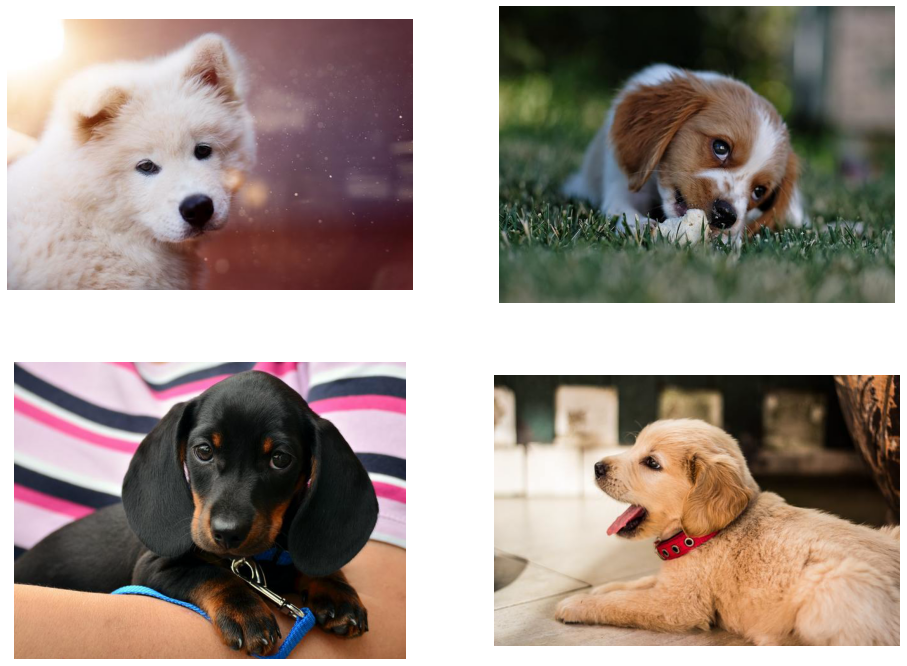

In [13]:
if __name__ == '__main__':
    parallel_out = parallel_pipe.run()
    display(parallel_out[0], batch_size)
    
    # let Python know that the pipeline will no longer be needed, so that
    # the worker processes and resources can be closed and freed.
    del parallel_pipe

### Spawn and Serialization of Functions

By default, local functions and lambdas are not picklable. If you are running **Python 3.8 or newer**, DALI will pickle such callbacks using a custom pickler that extends default pickle behavior.

Additionally, in order to work around the import issues in Jupyter notebook, you can mark a globally defined function to be serialized by value rather than by reference (the default behavior in Python).

If your version of Python is older than 3.8, refer to **Customizing Serialization** section for different ideas on how to serialize lambdas and local functions.

First, let's mimic `ExternalInputCallable` behavior using nested functions/closure.

In [14]:
def create_callback(batch_size):
    
    images_dir = "../../data/images/"
    with open(images_dir + "file_list.txt", 'r') as f:
        file_label = [line.rstrip().split(' ') for line in f if line != '']
        files, labels = zip(*file_label)
    full_iterations = len(files) // batch_size
    
    def callback(sample_info):
        sample_idx = sample_info.idx_in_epoch
        if sample_info.iteration >= full_iterations:
            # Indicate end of the epoch
            raise StopIteration
        jpeg_filename = files[sample_idx]
        label = np.int32([labels[sample_idx]])
        with open(images_dir + jpeg_filename, 'rb') as f:
            encoded_img = np.frombuffer(f.read(), dtype=np.uint8)
        return encoded_img, label
    
    return callback

Note how the outer function prepares the common configuration, the way `__init__` method does in `ExternalInputCallable`, and that the inner callback corresponds to `__call__` method.

In [15]:
@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0, py_num_workers=4, py_start_method='spawn')
def parallel_pipeline_with_closure():
    jpegs, labels = fn.external_source(source=create_callback(batch_size),
                                       num_outputs=2, batch=False, parallel=True,
                                       dtype=[types.UINT8, types.INT32])
    decode = fn.decoders.image(jpegs, device="mixed")
    return decode, labels

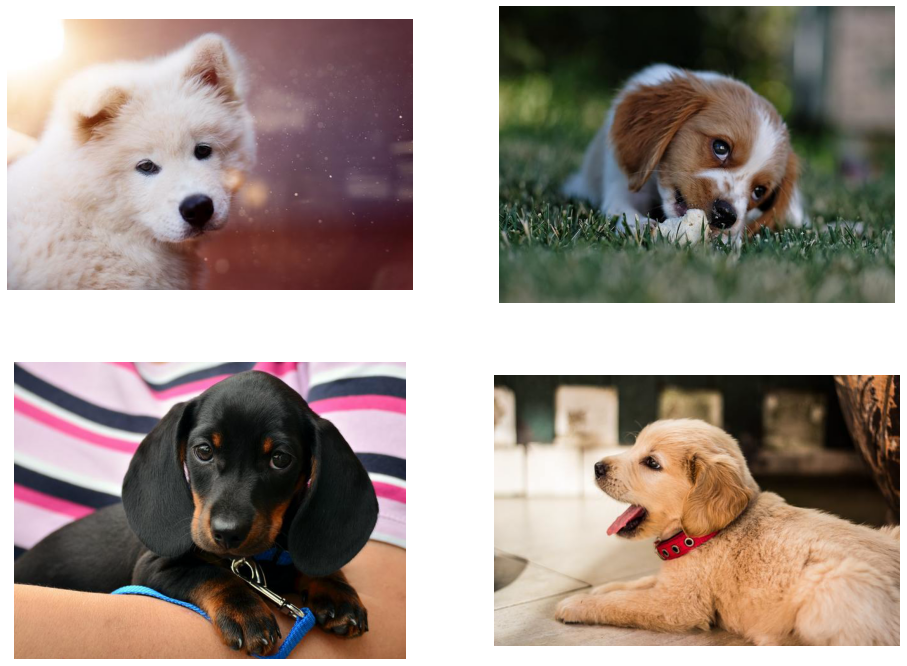

In [16]:
import sys

ver = sys.version_info
if ver.major < 3 or (ver.major == 3 and ver.minor < 8):
    print("This example works only in Python 3.8 or newer")
else:

    if __name__ == '__main__':
        parallel_pipe_with_closure = parallel_pipeline_with_closure()
        parallel_pipe_with_closure.build()
        
        parallel_out_with_closure = parallel_pipe_with_closure.run()
        display(parallel_out_with_closure[0], batch_size)
        
        # let Python know that the pipeline will no longer be needed, so that
        # the worker processes and resources can be closed and freed.
        del parallel_pipe_with_closure

#### pickle_by_value


When working with a Jupyter notebook, you may want to simply create your common configuration globally and create a callback that uses it, instead of writing nested functions. To make this approach work, you need to use a pickling method which serializes the entire function instead of the default one, which only stores the name and the defining module of the function.

In [17]:
import nvidia.dali.pickling as dali_pickle

images_dir = "../../data/images/"
with open(images_dir + "file_list.txt", 'r') as f:
    file_label = [line.rstrip().split(' ') for line in f if line != '']
    files, labels = zip(*file_label)
full_iterations = len(files) // batch_size


@dali_pickle.pickle_by_value
def global_callback(sample_info):
    sample_idx = sample_info.idx_in_epoch
    if sample_info.iteration >= full_iterations:
        # Indicate end of the epoch
        raise StopIteration
    jpeg_filename = files[sample_idx]
    label = np.int32([labels[sample_idx]])
    with open(images_dir + jpeg_filename, 'rb') as f:
        encoded_img = np.frombuffer(f.read(), dtype=np.uint8)
    return encoded_img, label

Note that the only thing required to make the above example work is `@dali_pickle.pickle_by_value` decorator.

In [18]:
@pipeline_def(batch_size=batch_size, num_threads=2, device_id=0, py_num_workers=4, py_start_method='spawn')
def parallel_pipeline_global_cb():
    jpegs, labels = fn.external_source(source=global_callback, num_outputs=2, batch=False,
                                       parallel=True, dtype=[types.UINT8, types.INT32])
    decode = fn.decoders.image(jpegs, device="mixed")
    return decode, labels

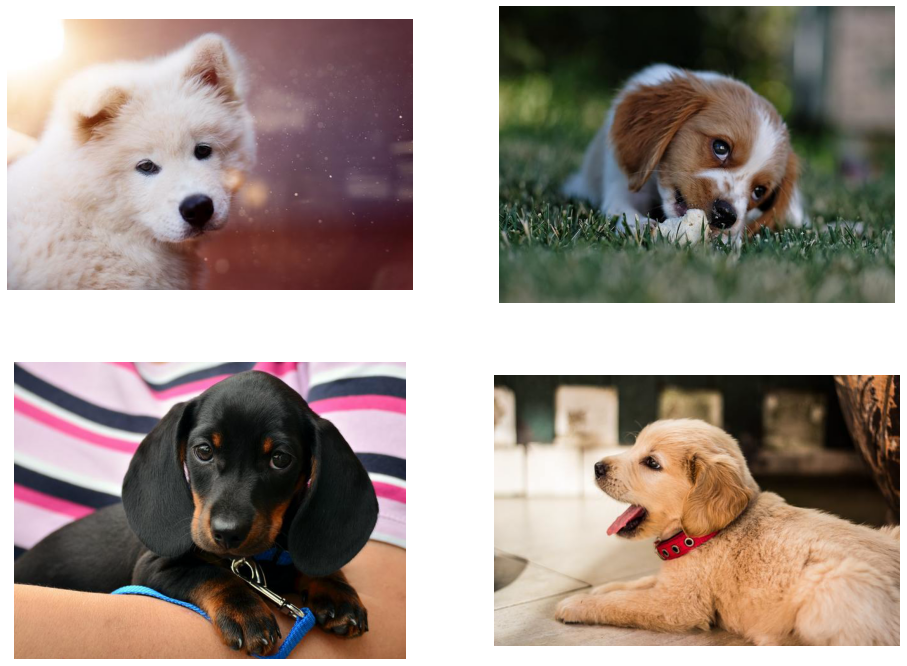

In [19]:
import sys

ver = sys.version_info
if ver.major < 3 or (ver.major == 3 and ver.minor < 8):
    print("This example works only in Python 3.8 or newer")
else:

    if __name__ == '__main__':
        parallel_pipe_global_cb = parallel_pipeline_global_cb()
        parallel_pipe_global_cb.build()
        
        parallel_out_global_cb = parallel_pipe_global_cb.run()
        display(parallel_out_global_cb[0], batch_size)
        
        # let Python know that the pipeline will no longer be needed, so that
        # the worker processes and resources can be closed and freed.
        del parallel_pipe_global_cb

### Customizing Serialization


Under the hood, DALI uses the standard pickling mechanisms for callbacks. If you need to customize the way your callbacks are pickled, consider implementing them as callable objects (`ExternalInputCallable` is an example of a class whose instances are callable).
You can control serialization of custom class by manually crafting `__getstate__` and `__setstate__` or `__reduce__` methods (you can find out more on this method in [pickle documenation](https://docs.python.org/3/library/pickle.html#pickling-class-instances)).
Alternatively, you can [register custom reducer for your class](https://docs.python.org/3/library/copyreg.html) via `dispatch_tables` mechanism.


If needed, you can make DALI serialize any type of callbacks with external package such as `dill` or `cloudpickle`. To make that happen, simply pass the desired module as `py_callback_pickler` parameter of the pipeline.
You may especially wish to do so when running Python version older than 3.8, to make lambas and local functions work with parallel `ExternalSource`.


Valid value for `py_callback_pickler` is either a module/object implementing `dumps` and `loads` methods or a tuple where the first item is the module/object and the next two optional parameters are extra kwargs to be passed when calling dumps and loads respectively.
The provided methods and kwargs must themselves be picklable with standard `pickle.dumps`.

Let's try the example with a closure again

In [20]:
def create_callback(batch_size):
    
    images_dir = "../../data/images/"
    with open(images_dir + "file_list.txt", 'r') as f:
        file_label = [line.rstrip().split(' ') for line in f if line != '']
        files, labels = zip(*file_label)
    full_iterations = len(files) // batch_size
    
    def callback(sample_info):
        sample_idx = sample_info.idx_in_epoch
        if sample_info.iteration >= full_iterations:
            # Indicate end of the epoch
            raise StopIteration
        jpeg_filename = files[sample_idx]
        label = np.int32([labels[sample_idx]])
        with open(images_dir + jpeg_filename, 'rb') as f:
            encoded_img = np.frombuffer(f.read(), dtype=np.uint8)
        return encoded_img, label
    
    return callback

In [21]:
try:
    import dill
except:
    print("This example requires dill package")
else:

    @pipeline_def(batch_size=batch_size, num_threads=2, device_id=0, py_num_workers=4,
                  py_start_method='spawn', py_callback_pickler=(dill, {'recurse': True}))
    def parallel_pipeline_with_dill():
        jpegs, labels = fn.external_source(source=create_callback(batch_size), num_outputs=2, batch=False,
                                           parallel=True, dtype=[types.UINT8, types.INT32])
        decode = fn.decoders.image(jpegs, device="mixed")
        return decode, labels

This time, we'll use dill to serialize the callback. We pass the additional `recurse=True` parameter to `dill.dumps` call, so that dill will try to trace what global objects are referred inside the serialized callbacks and need to be serialized along.

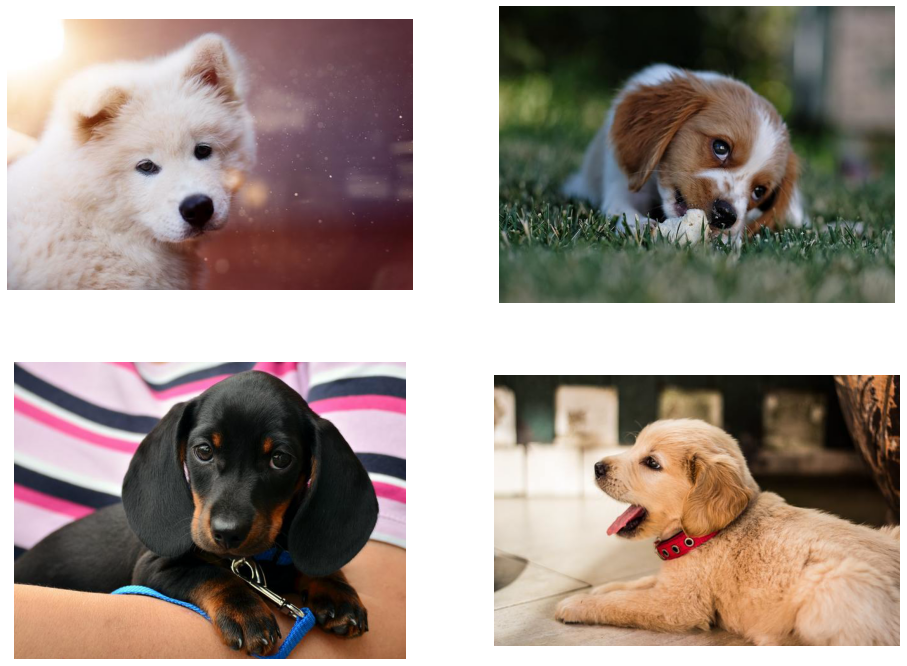

In [22]:
try:
    import dill
except:
    print("This example requires dill package")
else:

    if __name__ == '__main__':
        parallel_pipe_with_dill = parallel_pipeline_with_dill()
        parallel_pipe_with_dill.build()

        parallel_out_with_dill = parallel_pipe_with_dill.run()
        display(parallel_out_with_dill[0], batch_size)